### Research course submission

**Name :** Abhijith Sreesylesh Babu

**Paper :** Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps



# Generating a Class Model Visualization

The objective of this section is to generate a visualization of a class from an image classification model.

Starting from a pretrained classification model, we try to generate an image that is a generalization of a particular class. 

### Choosing a pretrained model

Here I am using VGG19, a pretrained image classification model that uses a deep convolution neural network to classify images into one of 1000 classes. It is a part of the torch vision models.

As shown below, the structure of the model can be divided into two sections - convolution and classification. 

In the convolution section, we generate learnable features from the images using the filters in convolution layer. We have a number of convolution 2D layers with ReLu activation functions and a number of maxpool layers to reduce the size of the feature-map.

In the classification section, we classify the image into one of the target classes using Linear feedforward layers with ReLu as the activation function.




In [1]:
# Importing the required libraries

import torch
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Loading and understanding the vgg19 model

model = models.vgg19(pretrained=True)
model.eval() # Setting the model to evaluation mode for inferencing


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Approach

Here the approach is to generate an image that has the highest class score when fed into the model.
We need to define a function f() that takes the image as a parameter and generates the class score for a particular class using the weights from the given model. Now we need to find the argmax of that fucntion along with a regularization term to find the optimal image

The classes of this model can be found by running the below resource.

In [3]:
import requests

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url)
classes = response.text.strip().split("\n")
for i in range(len(classes)):
    print(f"Class {i}: {classes[i]}")

Class 0: tench
Class 1: goldfish
Class 2: great white shark
Class 3: tiger shark
Class 4: hammerhead
Class 5: electric ray
Class 6: stingray
Class 7: cock
Class 8: hen
Class 9: ostrich
Class 10: brambling
Class 11: goldfinch
Class 12: house finch
Class 13: junco
Class 14: indigo bunting
Class 15: robin
Class 16: bulbul
Class 17: jay
Class 18: magpie
Class 19: chickadee
Class 20: water ouzel
Class 21: kite
Class 22: bald eagle
Class 23: vulture
Class 24: great grey owl
Class 25: European fire salamander
Class 26: common newt
Class 27: eft
Class 28: spotted salamander
Class 29: axolotl
Class 30: bullfrog
Class 31: tree frog
Class 32: tailed frog
Class 33: loggerhead
Class 34: leatherback turtle
Class 35: mud turtle
Class 36: terrapin
Class 37: box turtle
Class 38: banded gecko
Class 39: common iguana
Class 40: American chameleon
Class 41: whiptail
Class 42: agama
Class 43: frilled lizard
Class 44: alligator lizard
Class 45: Gila monster
Class 46: green lizard
Class 47: African chameleon


Here I am choosing class 543 which represents dumbbell.

I start with a random zero-image of dimension 480x480 with 3 color channels. I am using an adam optimizer to update the image based on the loss function. I consider 1500 as a target lose function to make better approximation of the loss function The loss function will be (target - class_score) + regularization term.

Finally the image is clamped to make sure the pixel values fall in the permitted range.

In [4]:
input_image = torch.zeros((1, 3, 480, 480), requires_grad=True)
optimizer = torch.optim.Adam([input_image], lr=0.075)
target_class = 543 # Class ID for dumbbell
lambda_reg = 1e-6   # Regularization parameter
target_score = 1500

In [5]:
import tqdm # For tracking the progress of the iterations
for step in tqdm.tqdm(range(200)):  
    optimizer.zero_grad()
    
    # Forward pass to get the class score of the input image
    output = model(input_image)
    score = output[0, target_class]  
    
    # Regularization term
    l2_reg = lambda_reg * torch.norm(input_image)
    
    # Backpropagation of the loss
    loss = (target_score - score) + l2_reg
    loss.backward()  
    
    # Update the image pixels using the gradients
    optimizer.step()
    
    # Clamp pixel values to the range [0, 1]
    input_image.data.clamp_(0, 1)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [14:50<00:00,  4.45s/it]


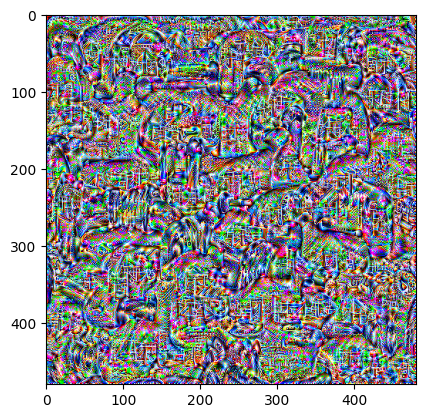

In [6]:
# Visualizing the generated image

# Converting the tensor to a PIL image in required format
output_image = input_image.detach().squeeze().permute(1, 2, 0).numpy()

plt.imshow(output_image)
plt.show()

Here we observe some shapes similar to the dumbbell which can be the features that are learnt by the model to classify an image as dumbbell

# Image specific class saliency visualization

In this section, I aim to generate saliency map of an image with respect to its class. i.e, for a given image and a class, I aim to highlight the portions of the image that contributed most to be classified as the particular class.

Here I am using the VGG19 model the following 4 images

1. Hen (Class-8)
2. cup (Class-968)
3. hammer (Class-587)
4. violin (Class-889)




### Loading the model

I am loading the vgg19 model from the torchvision library. The model is set to evaluation mode as we do not need to update the weights of the model

In [7]:
# Importing necessary libraries

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import maxflow
from sklearn.mixture import GaussianMixture
from scipy.ndimage import label, find_objects


In [8]:
#  Loading the Pre-trained VGG19 Model

model = models.vgg19(pretrained=True)
model.eval()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Defining the images and classes used in this experiment.

I stored the images in the ```/images``` folder. Here I am creating a list of all the images along with their class numbers.

In [9]:
# Creating an image list

images = [
    ["images/hen.jpg", 8],
    ["images/cup.jpg", 968],
    ["images/hammer.jpg", 587],
    ["images/violin.jpg", 889]
]

### Approach

To find the effect of a pixel on the class score, we can compute the rate of change of the class score with respect to the pixel. i.e. we can find the gradient of the pixel with respect to the class score. According to the paper, backpropagation is used to 

My approach is to pass the image into the model once and do a backward pass so that I can use the gradients obtained after the backpass

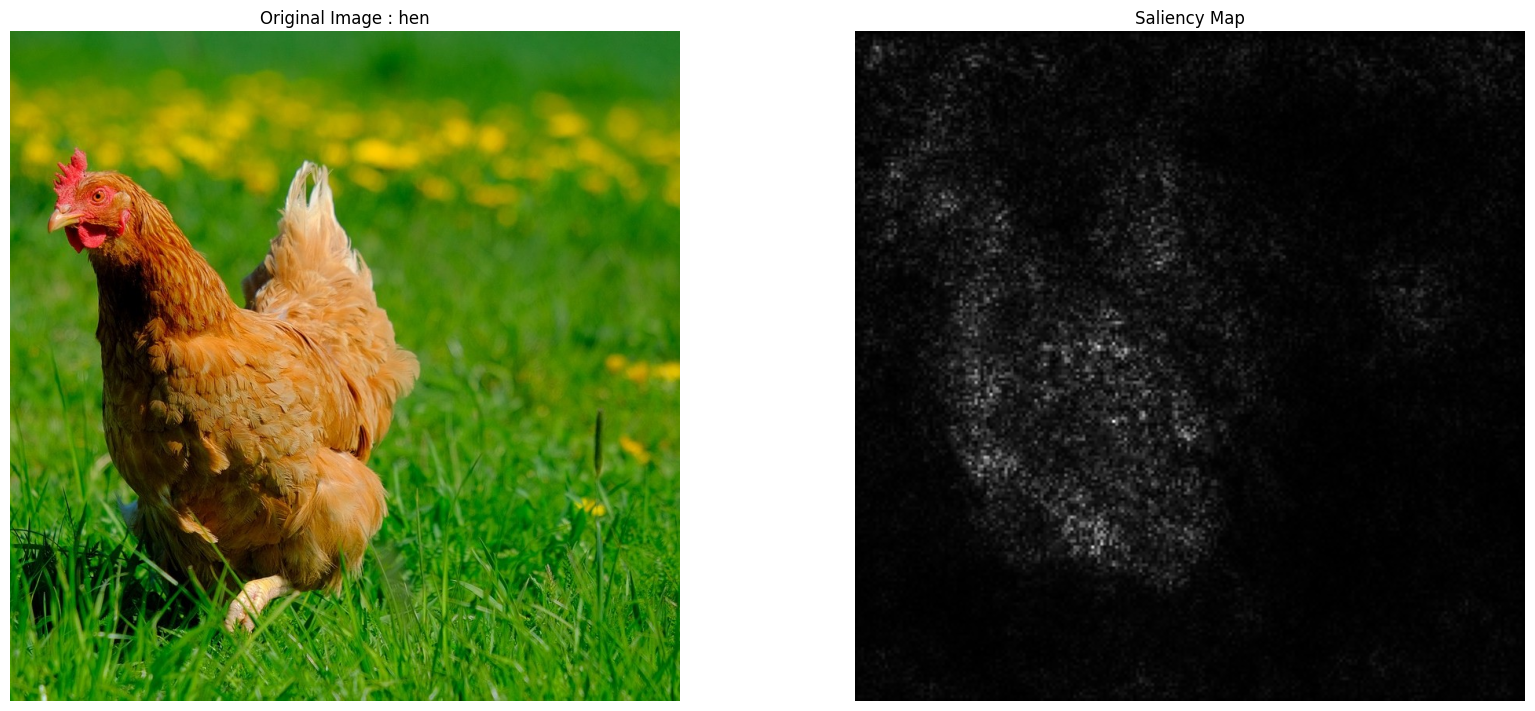

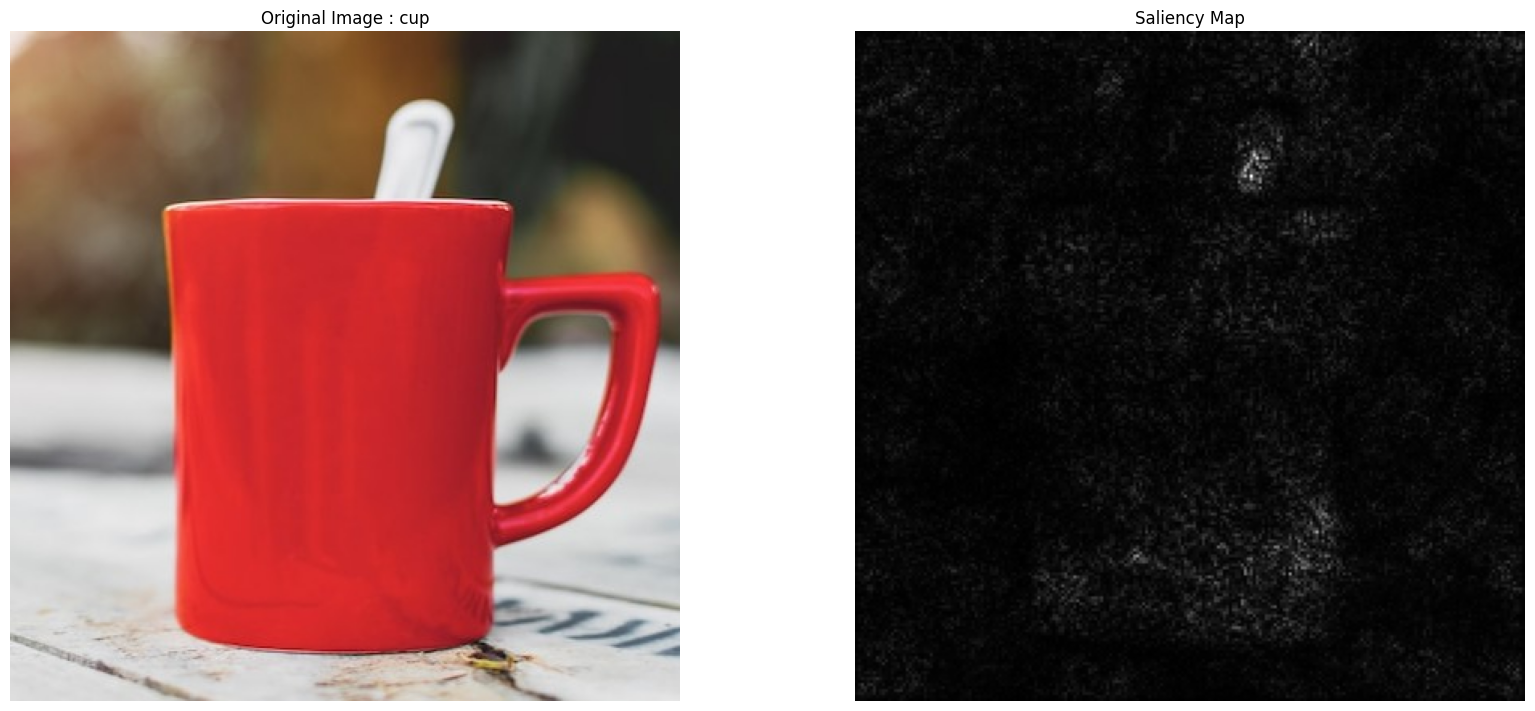

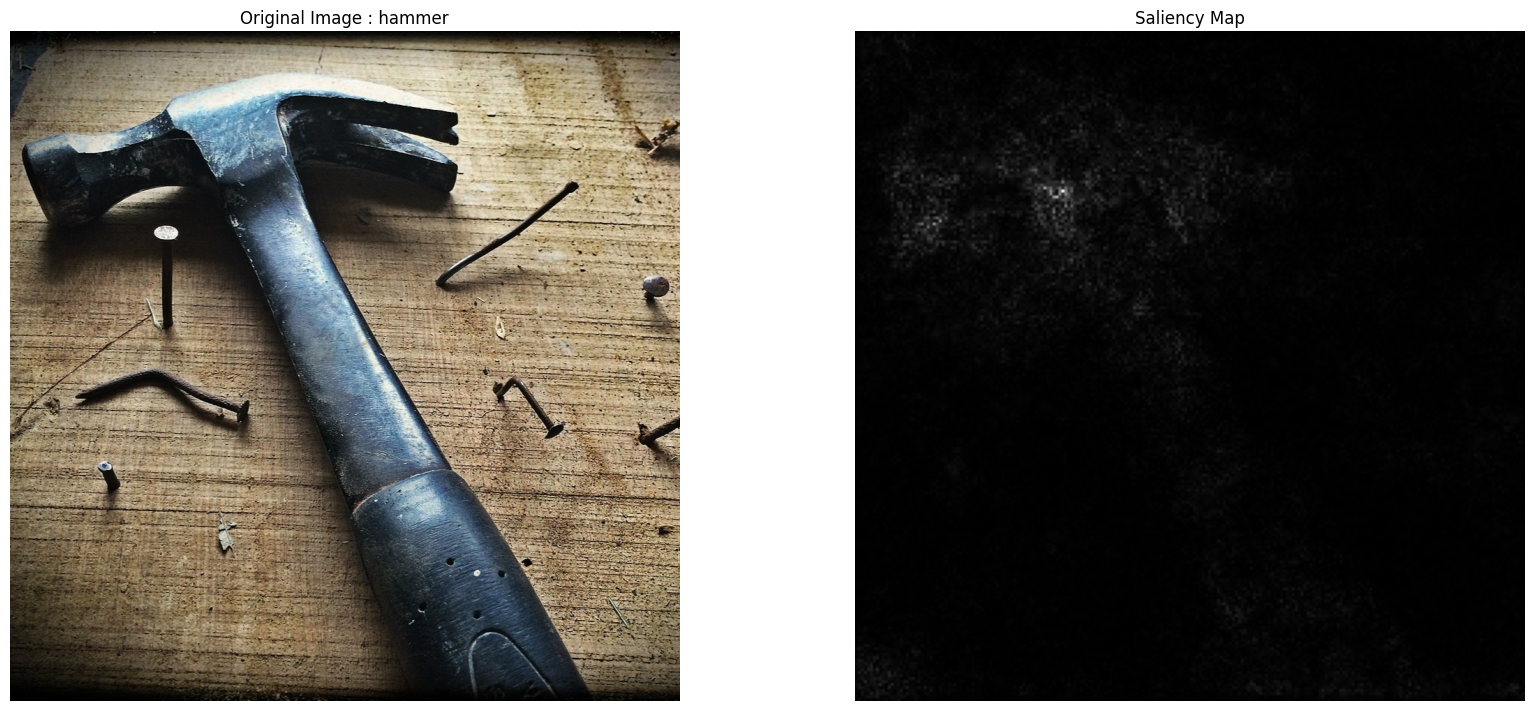

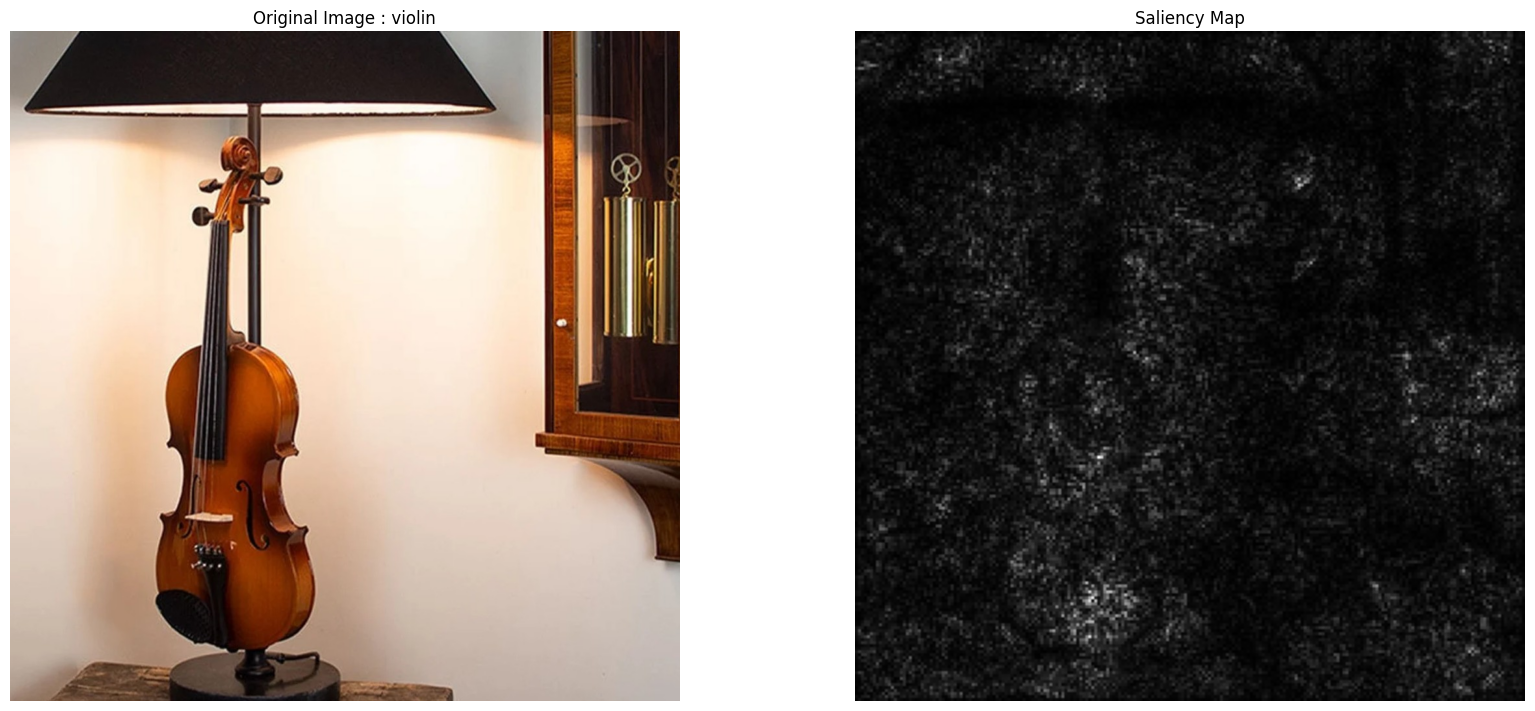

In [10]:
saliency_storage = {}

# looping through the images

for img in images:
    img_path = img[0]
    class_num = img[1]
    image = Image.open(img_path)
    
    # transforming and normalizing the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image)
    input_image = input_image.unsqueeze(0) # Extra dimension required for torch models
    
    # Enabling gradient tracking for the image
    input_image.requires_grad_()
    
    # Doing a forward pass on the model
    class_scores = model(input_image)
    target_score = class_scores[0, class_num]
    
    # Clearing the model gradients
    model.zero_grad()
    
    # Doing a backward pass on the model
    target_score.backward()
    
    # Getting the gradient of the image
    gradients = input_image.grad.data
    
    # Calculating the saliency map by taking the absolute value of the gradients and averaging across the color channels
    saliency_map = gradients.abs().mean(dim=1)[0]
    
    # Normalizing the saliency map to a range of 0 to 1
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    saliency_map = saliency_map.squeeze().numpy()
    
    # Storing the saliency map
    saliency_storage[img_path] = saliency_map
    
    # creating a plot for visulization
    
    plt.figure(figsize=(20, 40))
    
    # Displaying the original image    
    plt.subplot(len(images), 2, 2 * images.index(img) + 1)
    plt.imshow(image)
    plt.title("Original Image : " + img_path.split("/")[-1].split(".")[0])
    plt.axis('off')
    
    #Displaying the saliency map
    plt.subplot(len(images), 2, 2 * images.index(img) + 2)
    plt.imshow(saliency_map, cmap='grey')
    plt.title("Saliency Map")
    plt.axis('off')
    
    plt.show()    
    
    
    
    

# Weakly Supervised Image Localization

After classifying an image into a particular class, we can use the saliency map to localize the object of interest in that image.

### Approach

The saliency value of a pixel in the image is an indicator of whether the pixel belongs to the object of interest. So if the saliency value is above a certain threshold, then that pixel is most likely in the object of interest.

To localize the object of interest, I define two regions, foreground and background, each with a separate threshold. Using these values, I identify the pixels that belongs to the foreground and background regions.

Here I am using the 95% and 30% quantile value as the foreground and background threshold as used in the paper.

Now I apply gaussian mixture model to classify the rest of the pixels into foreground or background image. The Gaussian Mizxture models are applied on a graph created from the saliency map.




(224, 224) (224, 224)
(224, 3, 224)


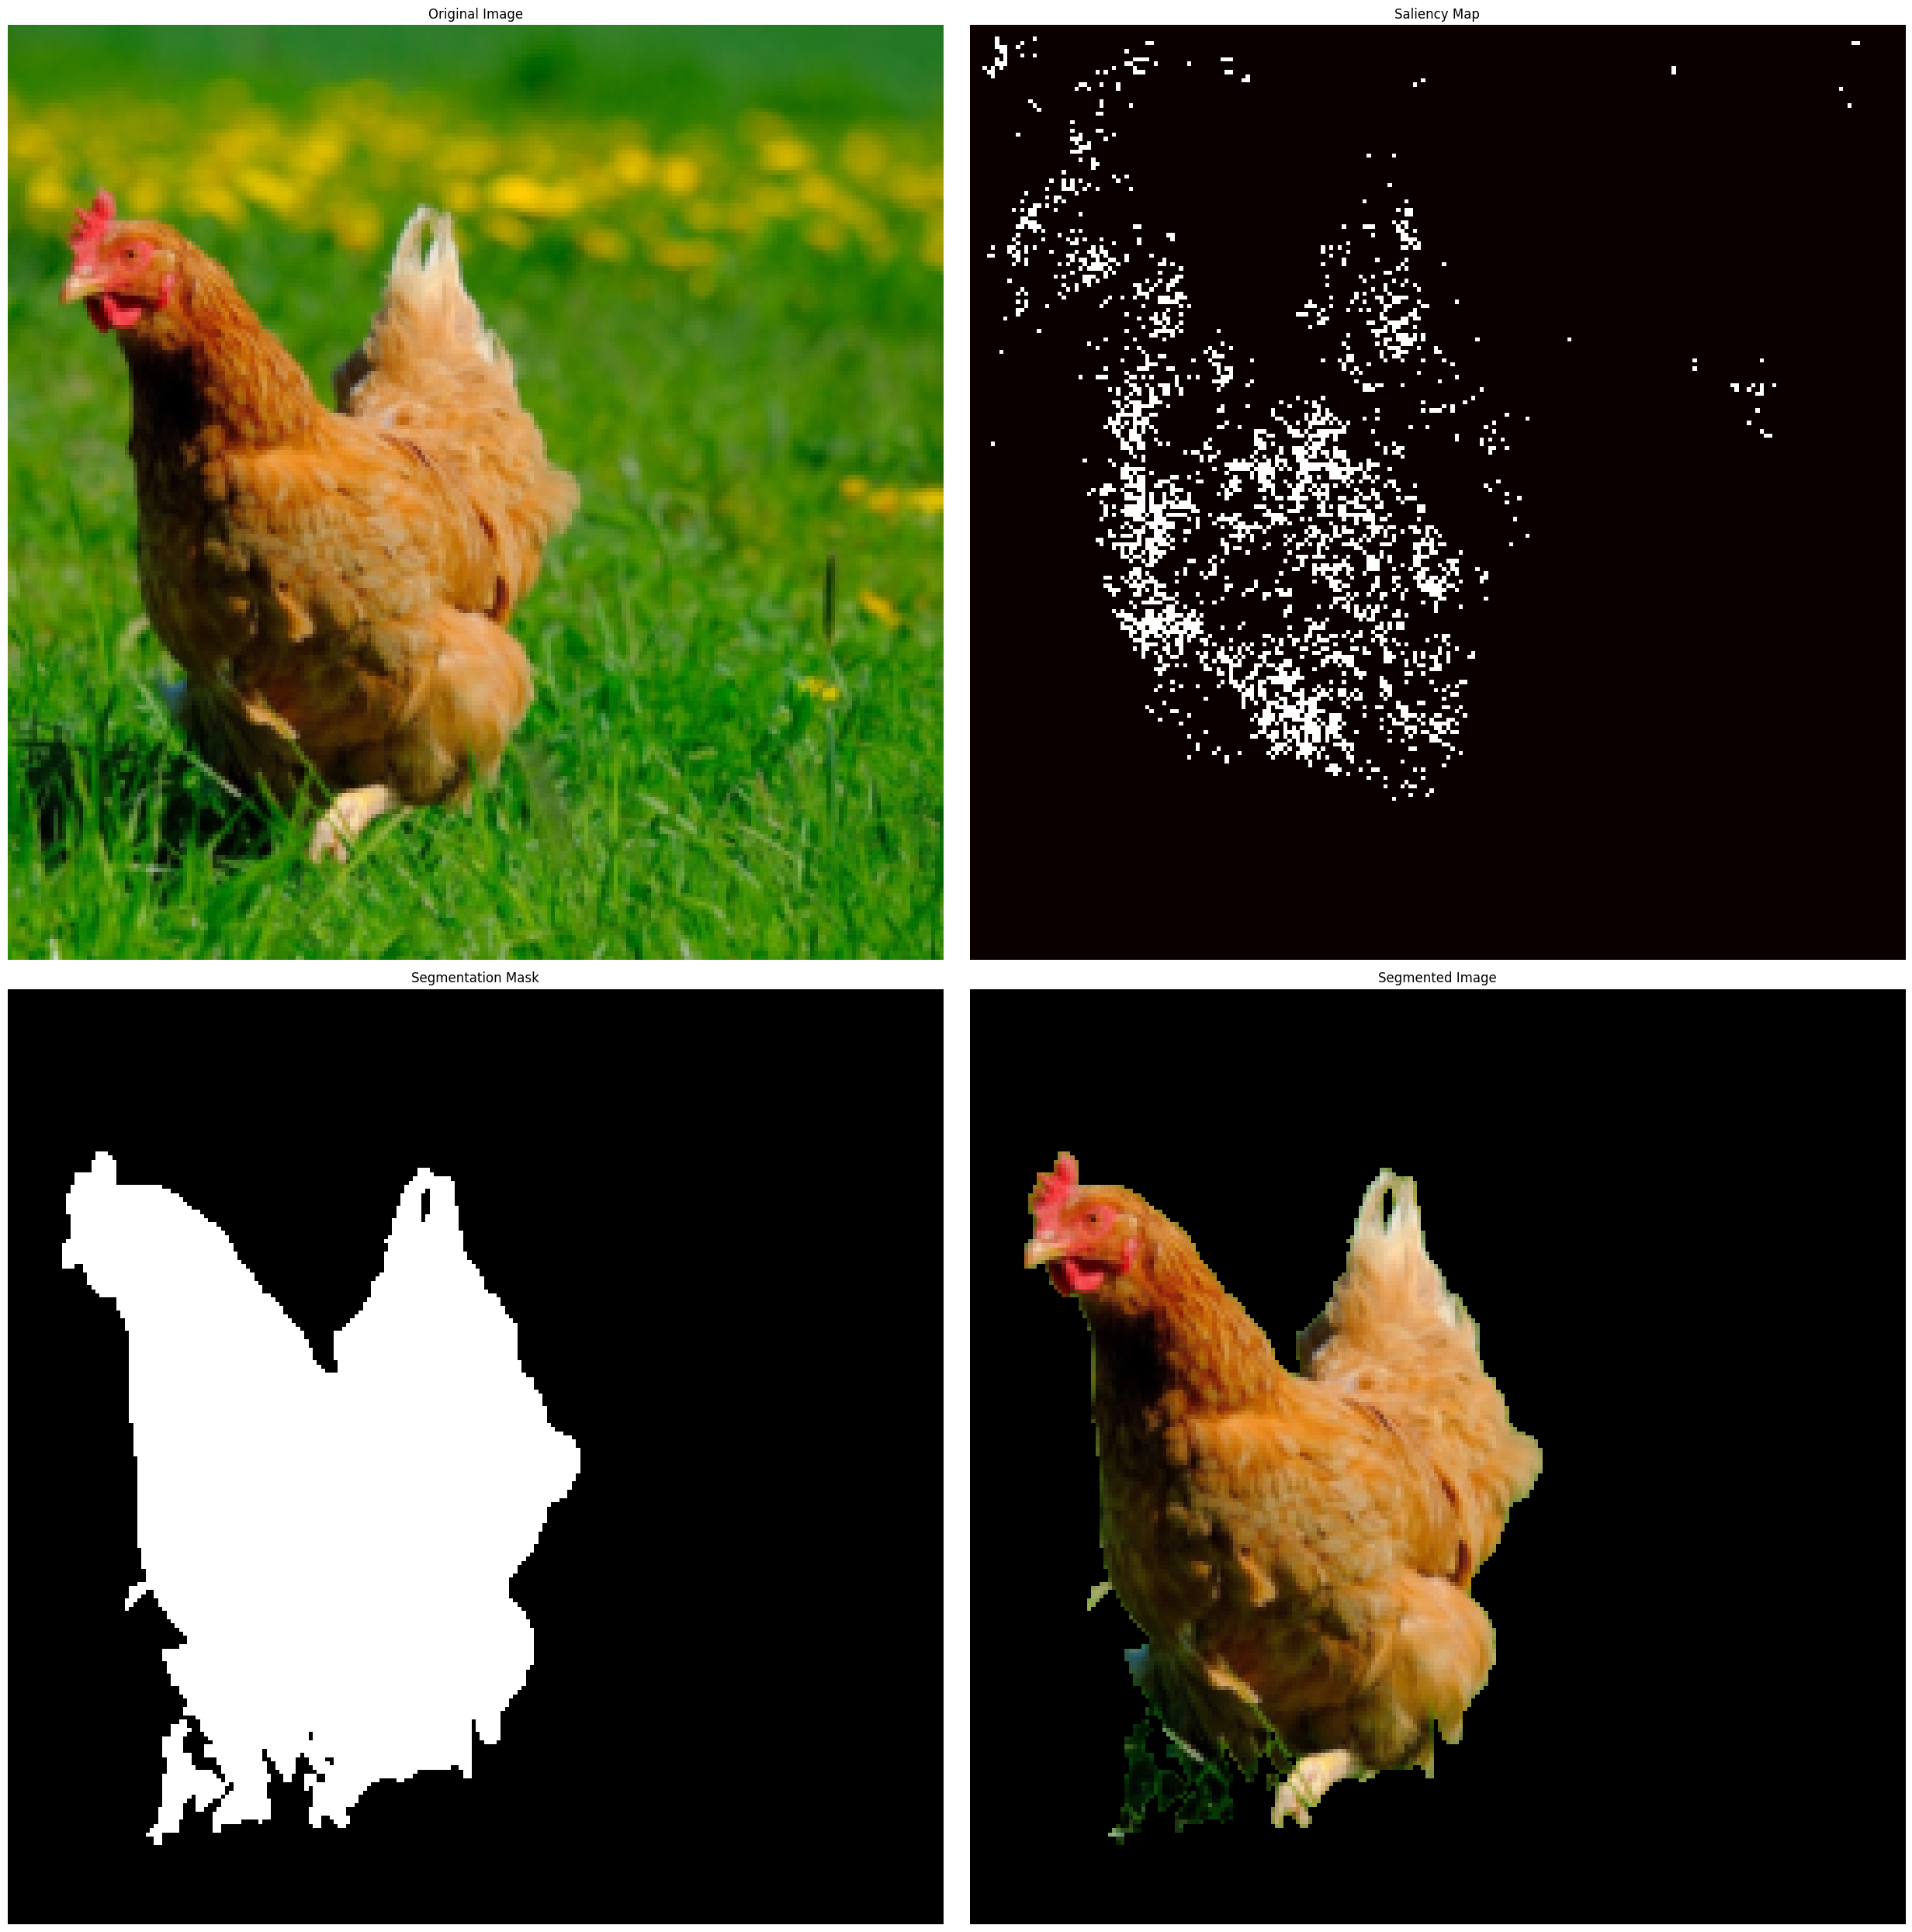

(224, 224) (224, 224)
(224, 3, 224)


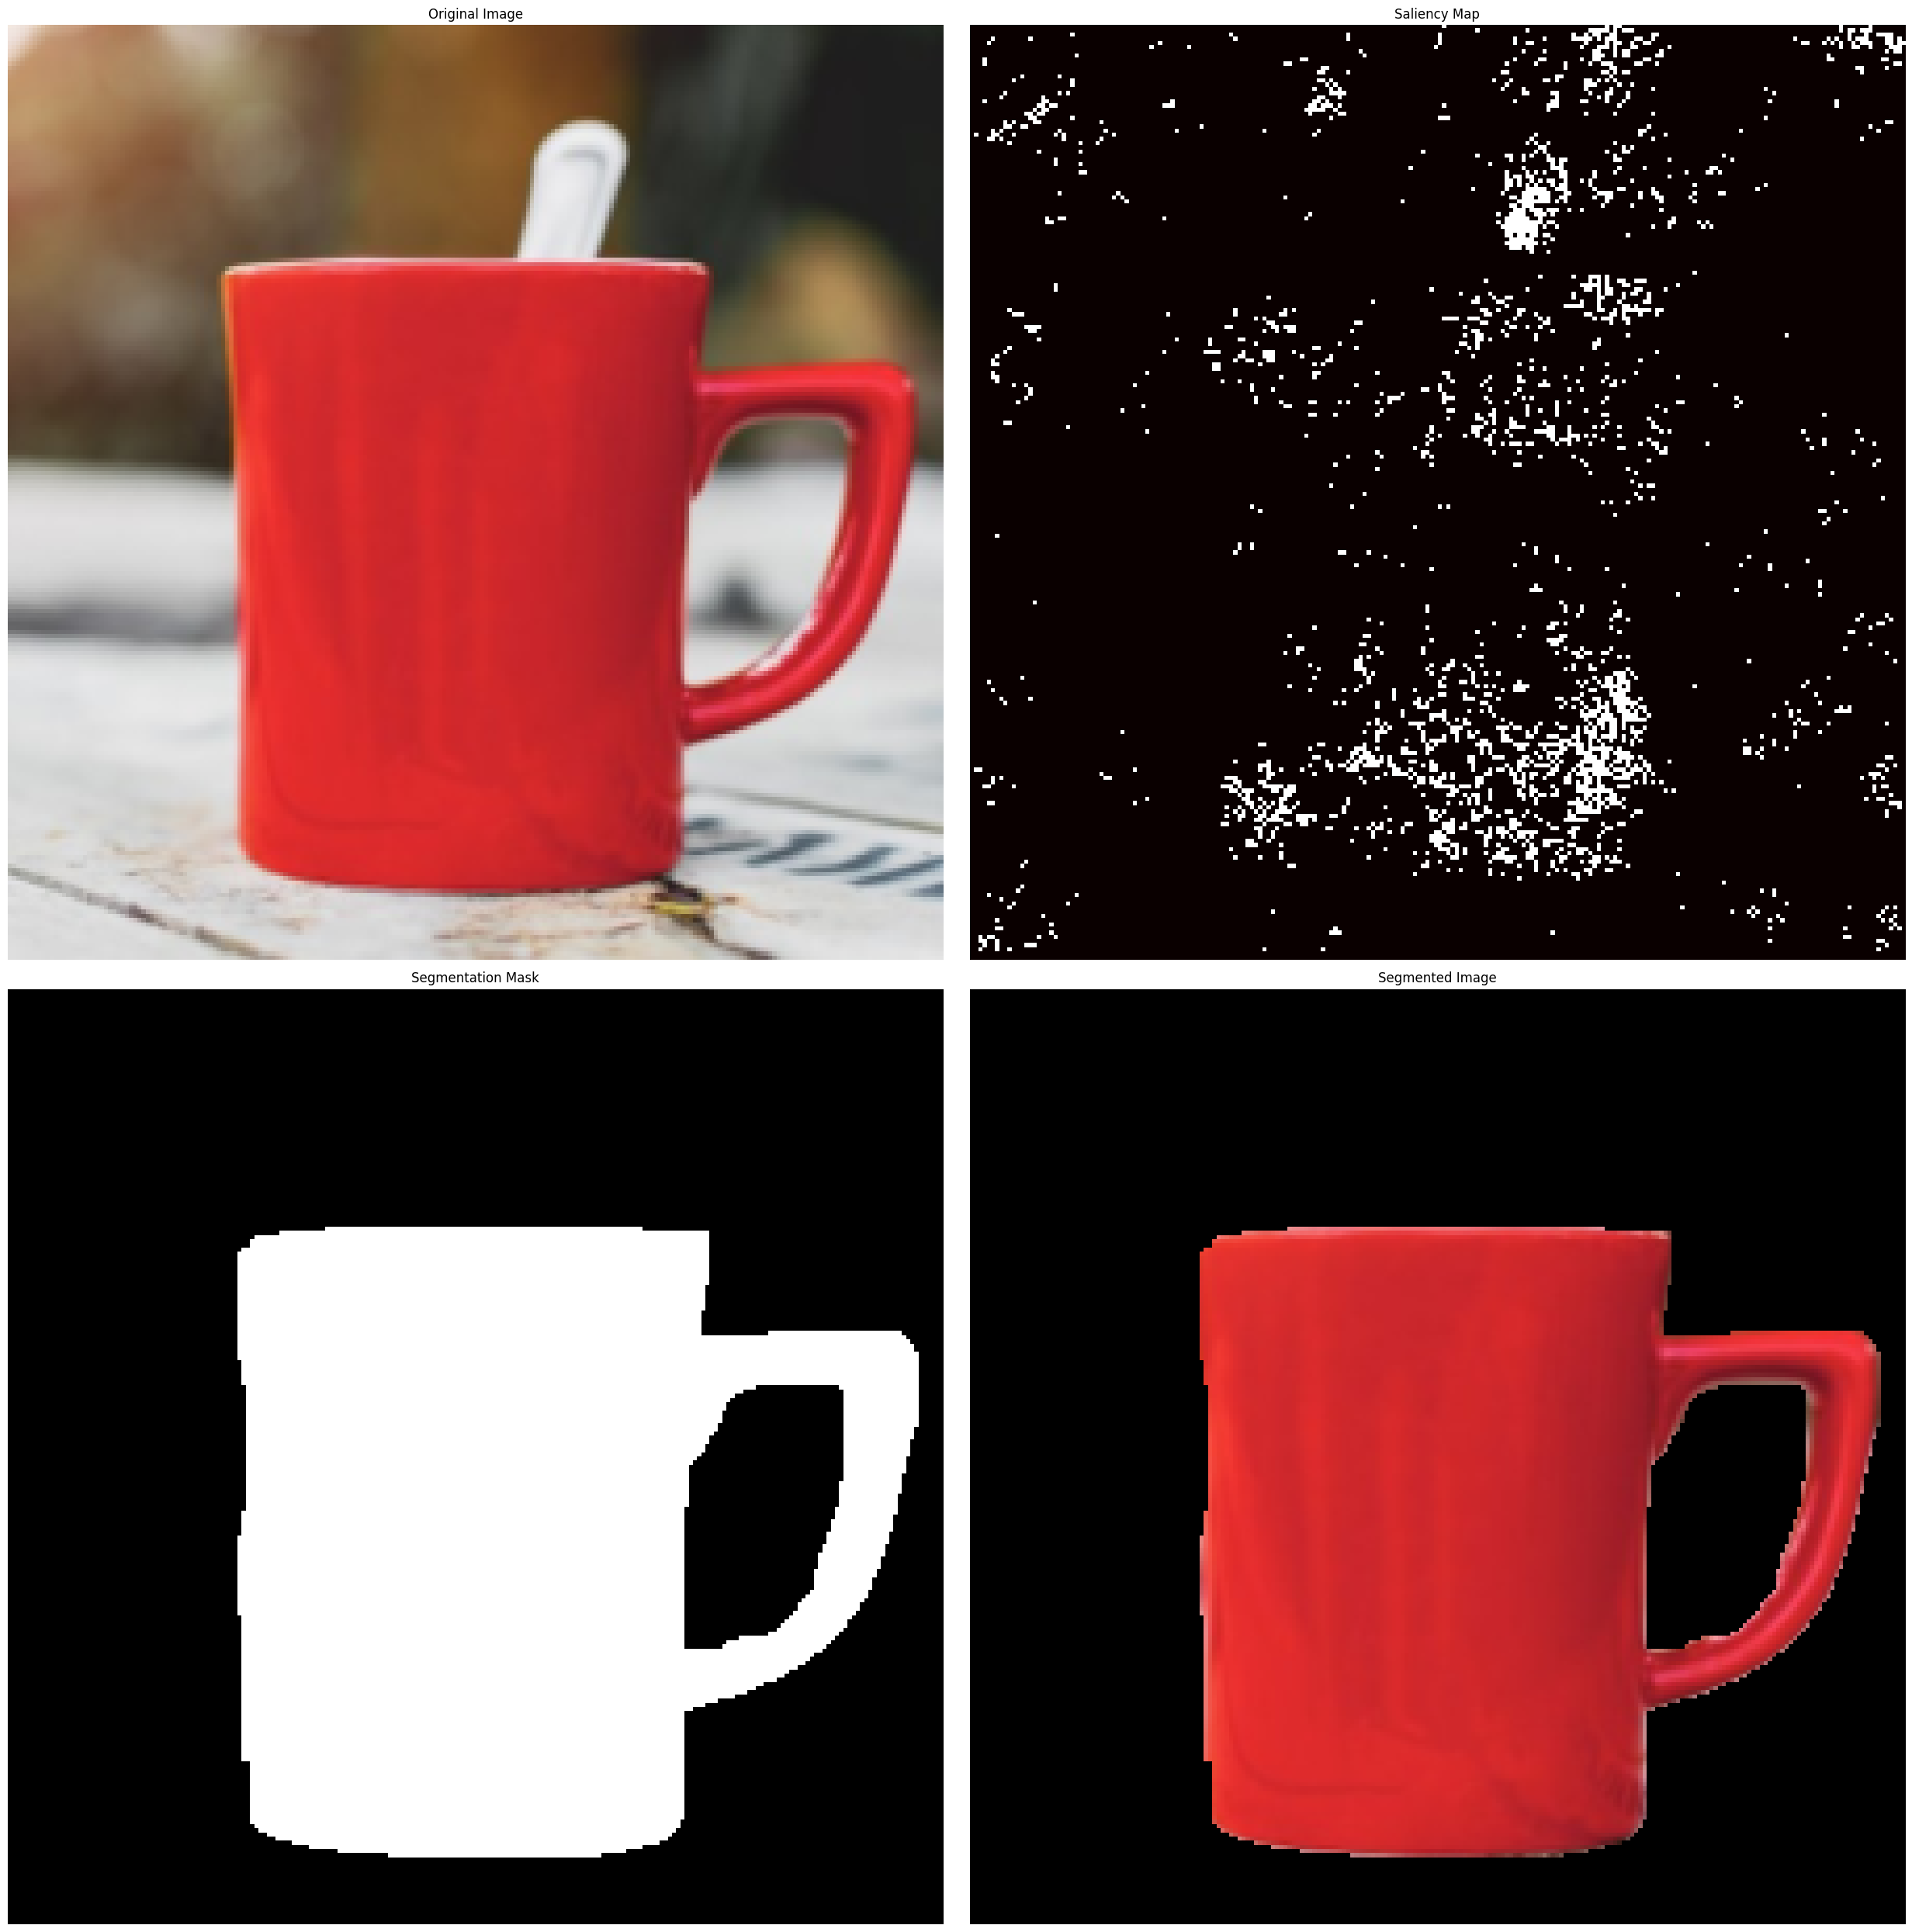

(224, 224) (224, 224)
(224, 3, 224)


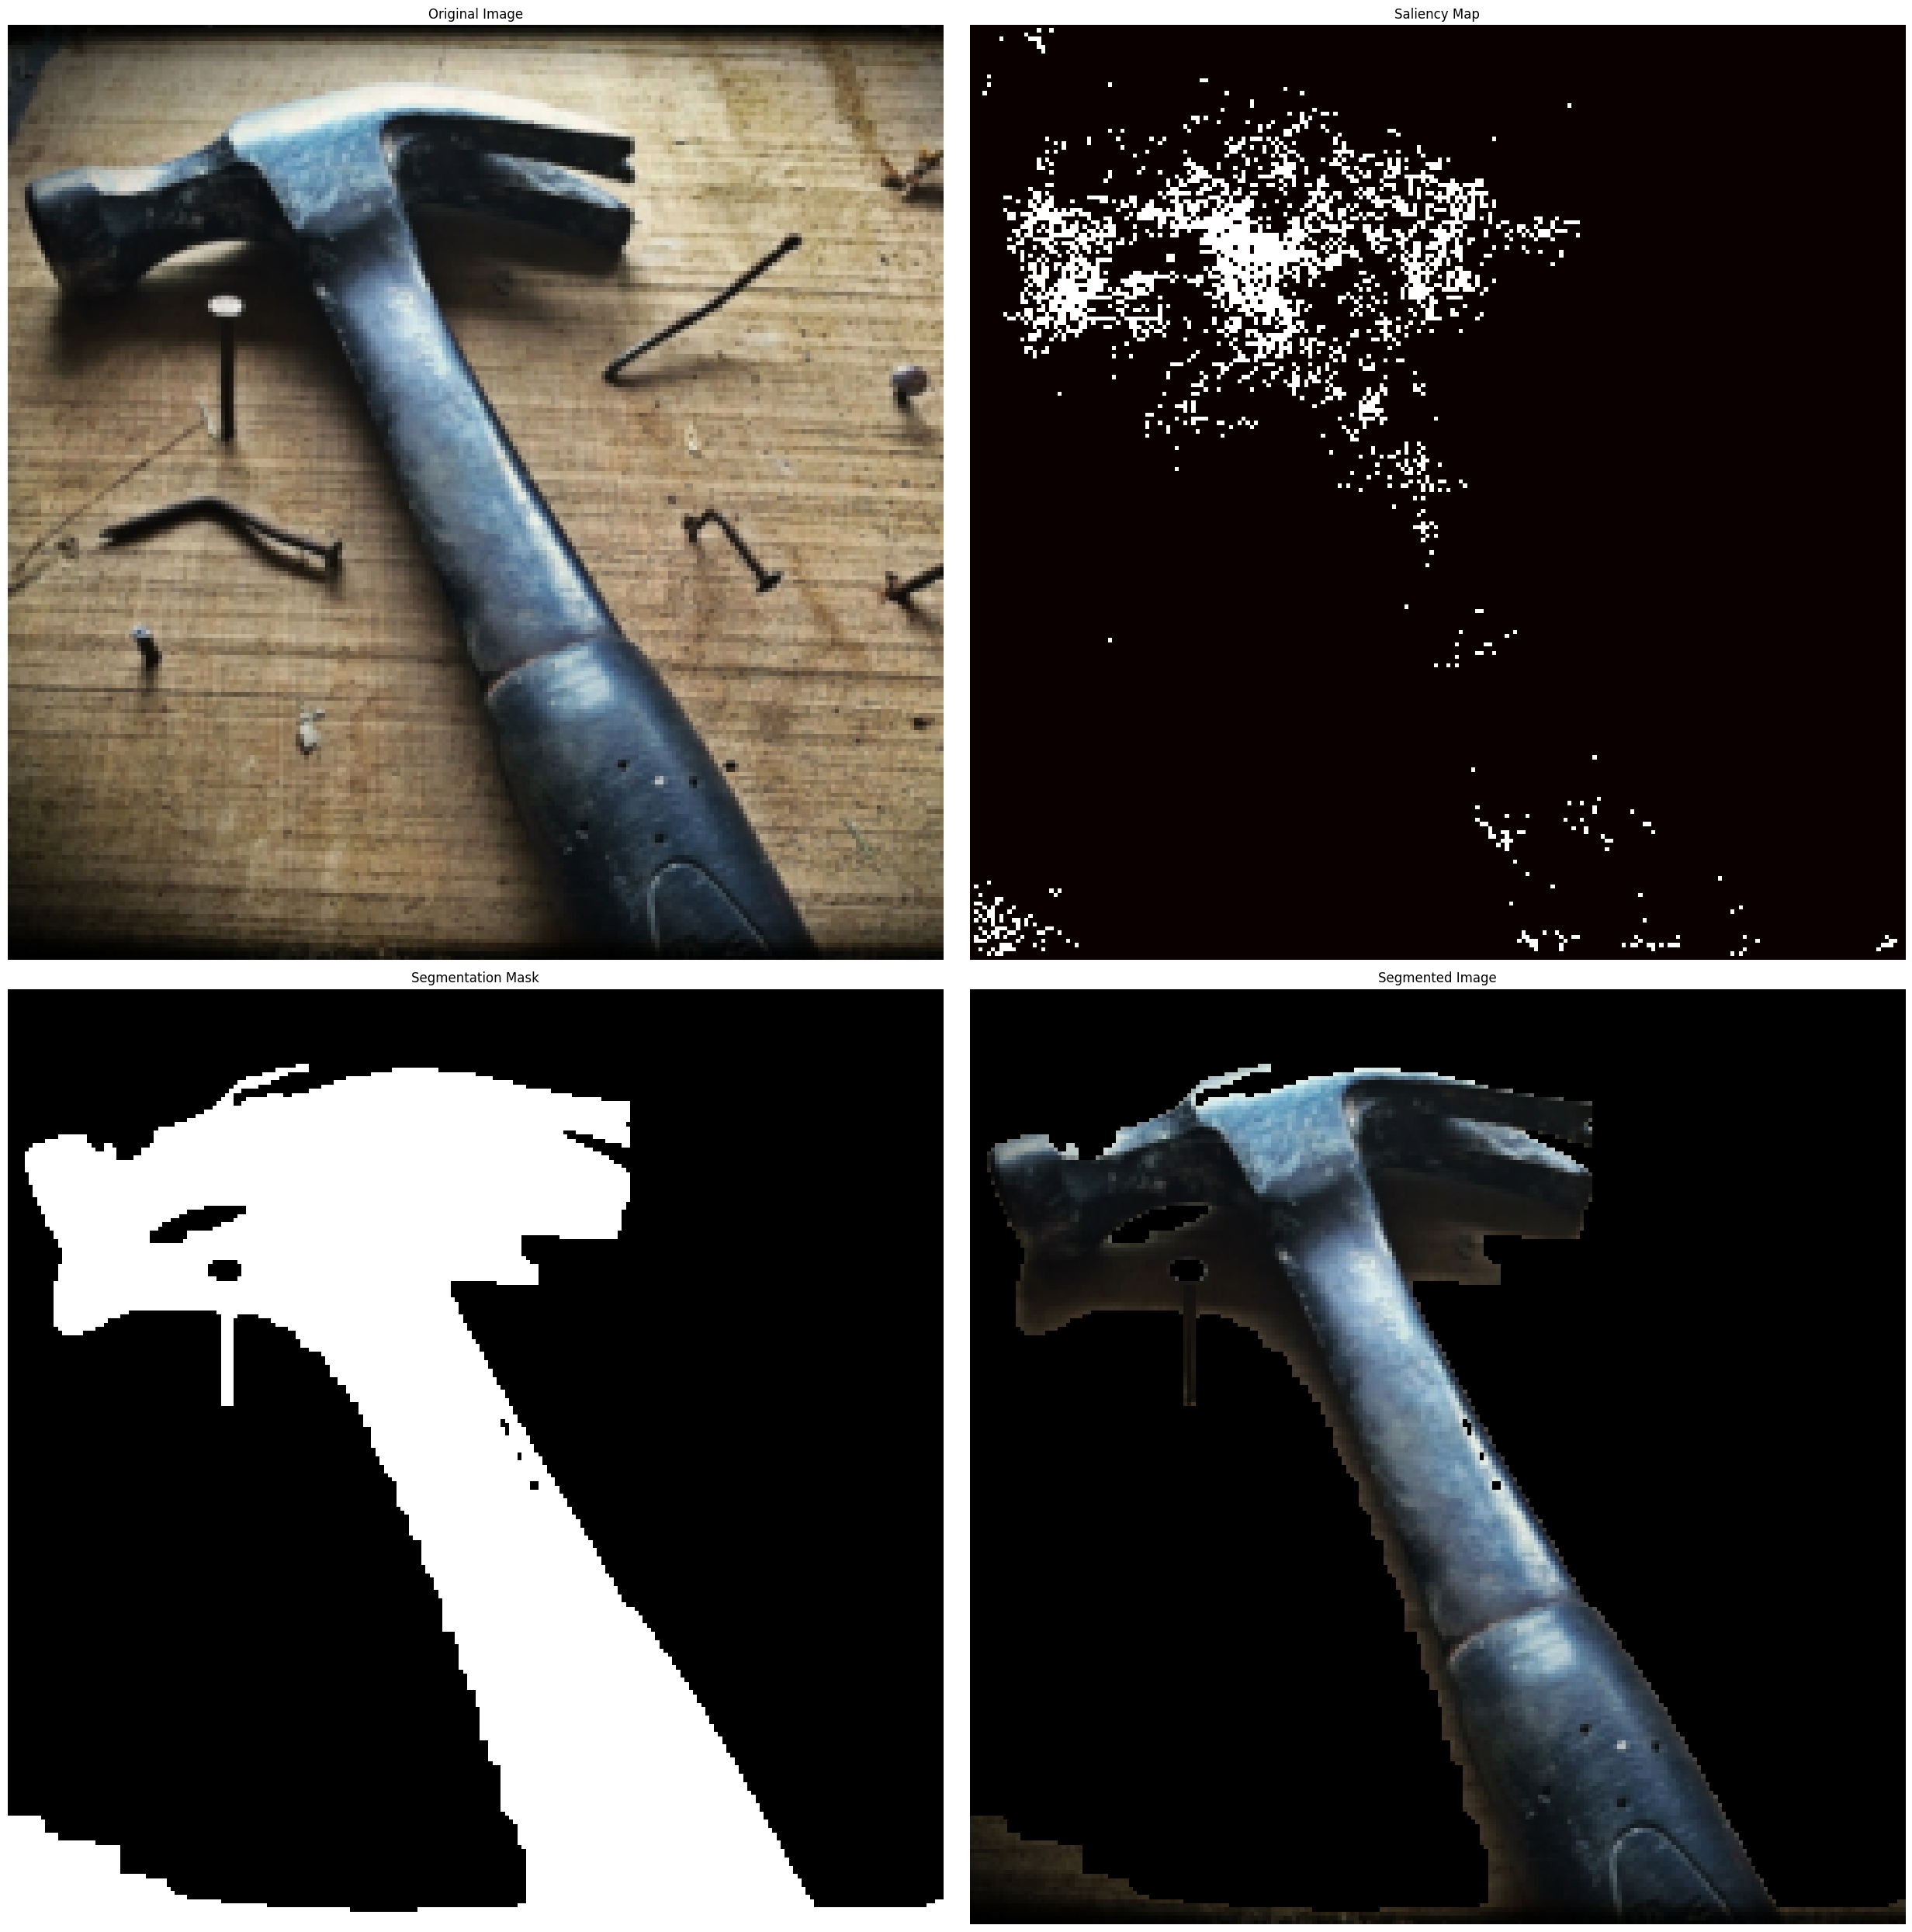

(224, 224) (224, 224)
(224, 3, 224)


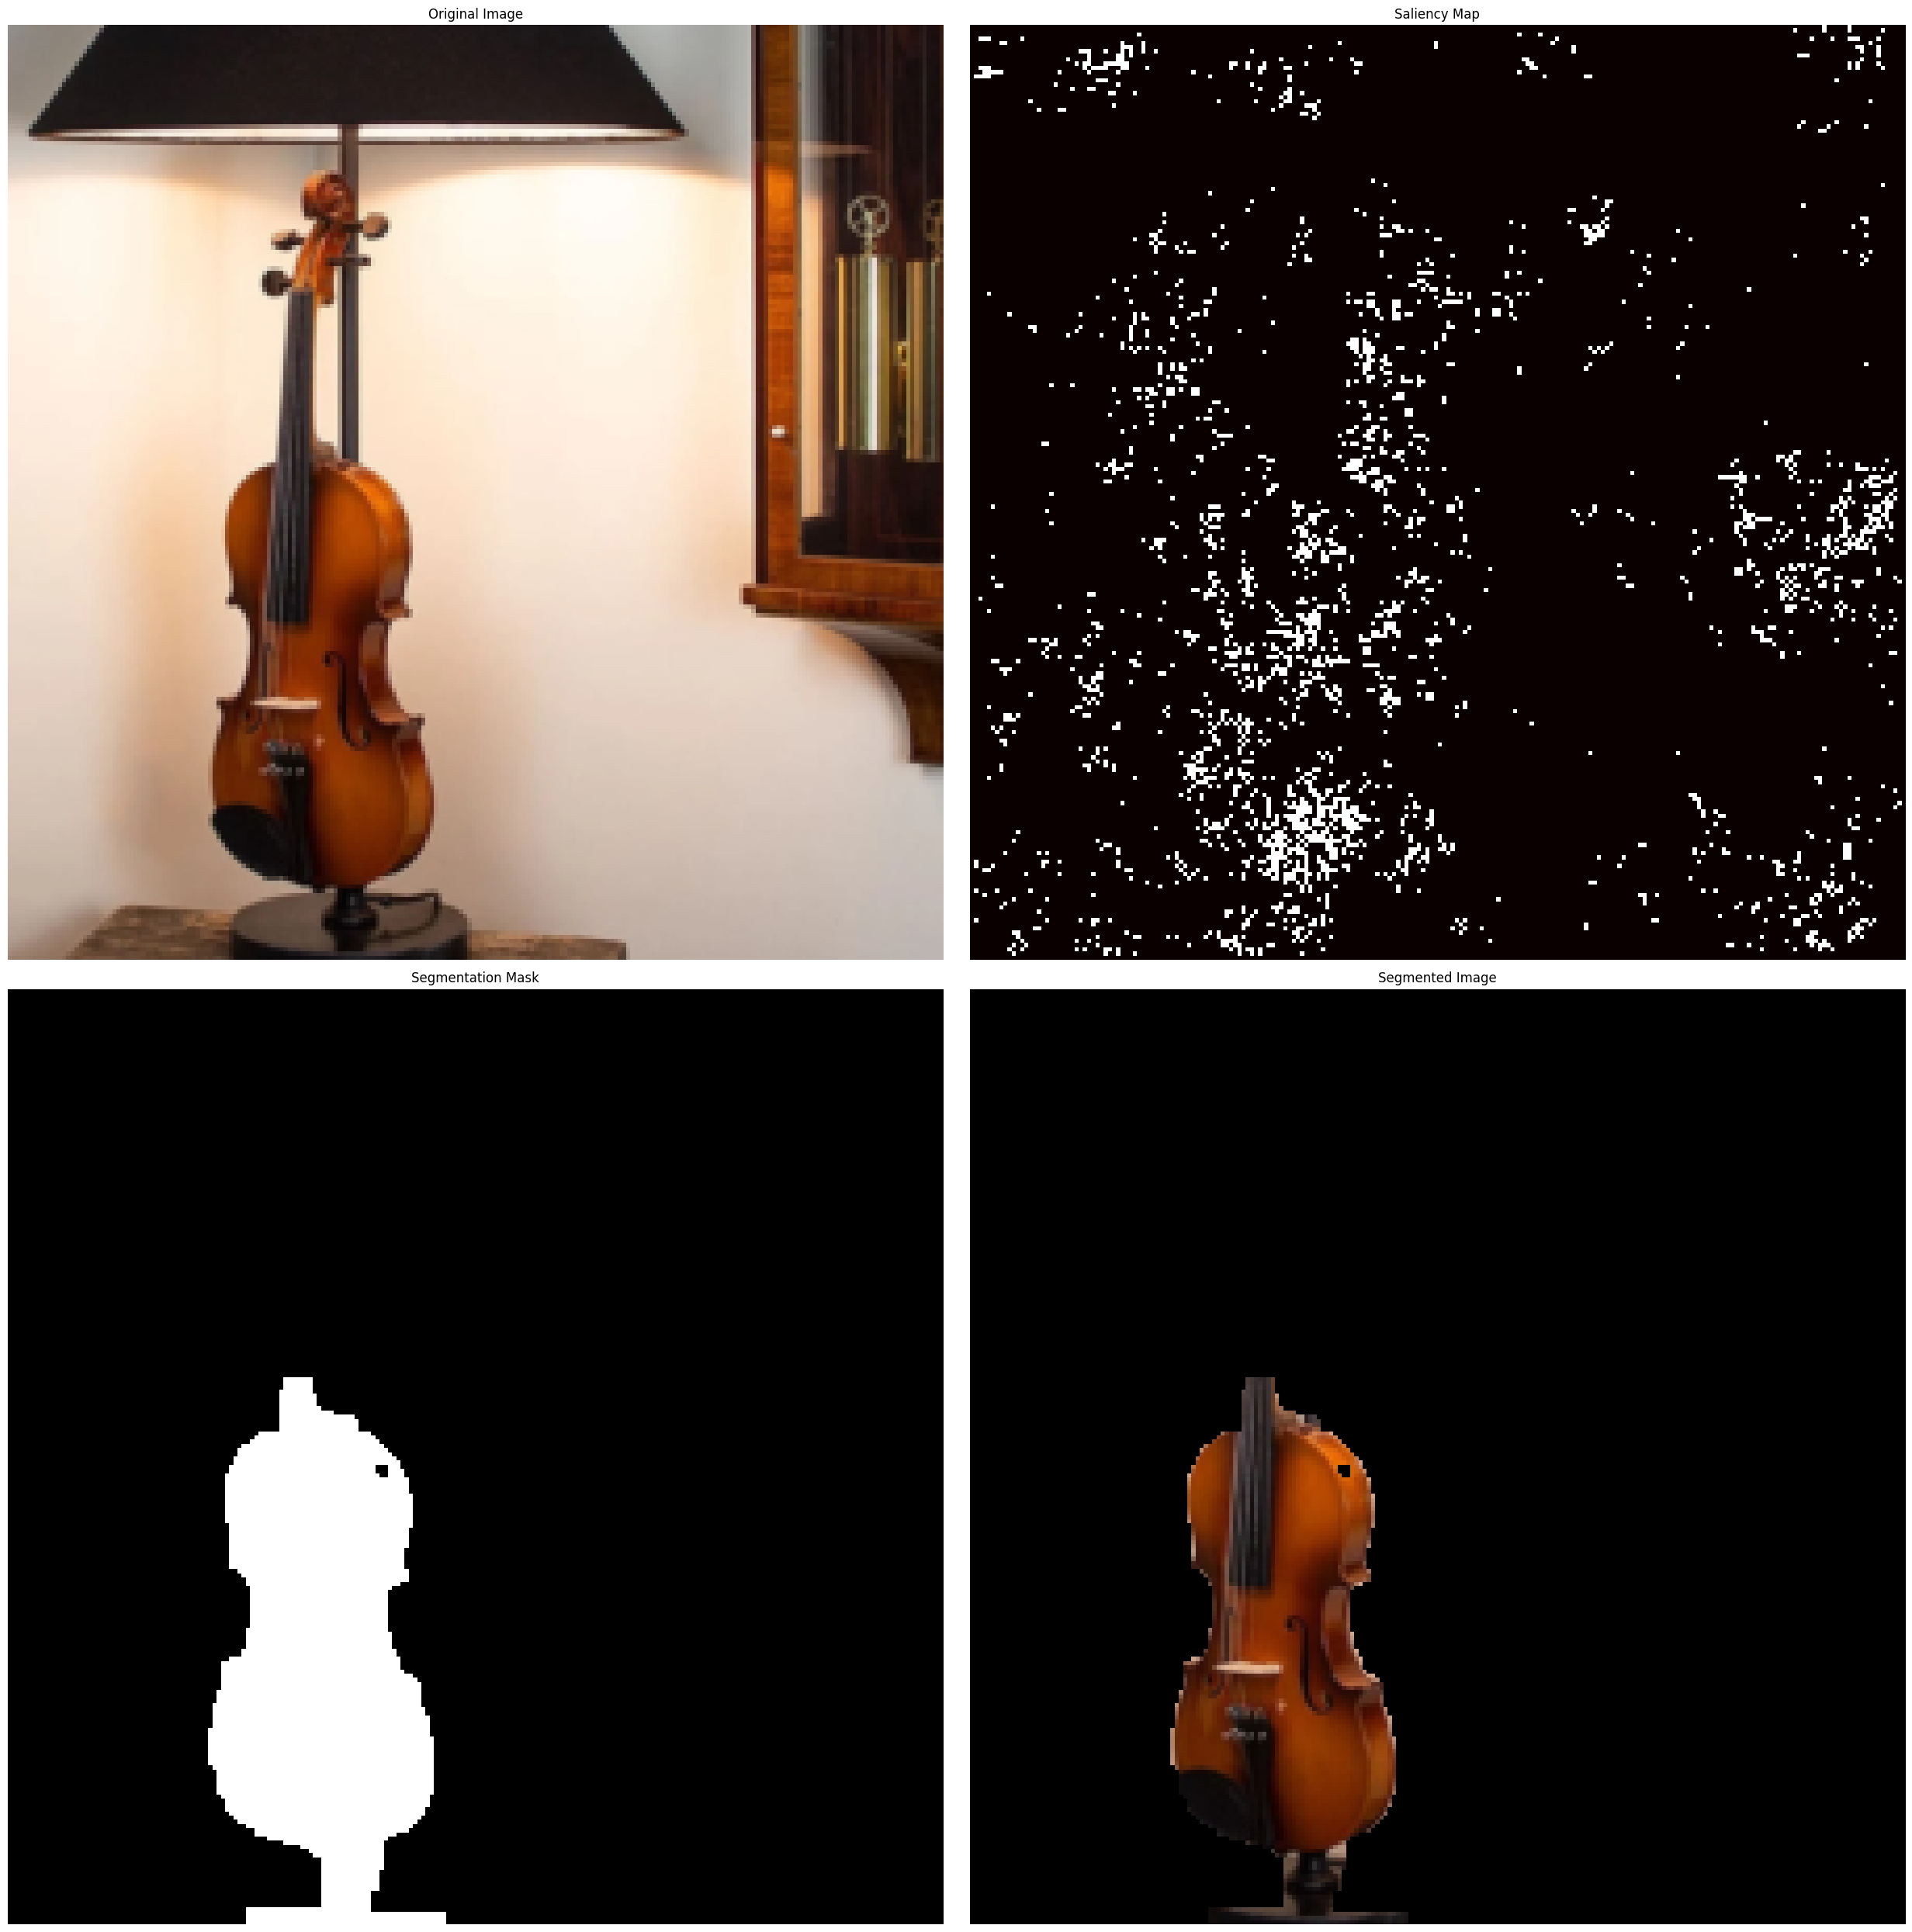

In [11]:
for img in images:
    img_path = img[0]
    class_num = img[1]
    
    # loading the image
    image = Image.open(img_path)
    
    # Applying transdormations to the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)
    
    # loading the saliency map
    saliency_map = saliency_storage[img_path]
    
    # calculating the threshold value for the saliency map
    threshold_high = np.quantile(saliency_map, 0.95)
    threshold_low = np.quantile(saliency_map, 0.3)
    
    # creating a binary mask for the saliency map
    foreground_mask = (saliency_map > threshold_high).astype(np.uint8)
    background_mask = (saliency_map < threshold_low).astype(np.uint8)
    
    # Reshaping the image to fit into Gaussian Mixture Model
    image_reshaped = np.asarray(image).reshape(-1, 3)
    
    # creating foreground gaussian mixture model
    foreground_px = image_reshaped[foreground_mask.flatten() == 1]
    foreground_gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=0)
    foreground_gmm.fit(foreground_px)
    
    # creating background gaussian mixture model
    background_px = image_reshaped[background_mask.flatten() == 1]
    background_gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=0)
    background_gmm.fit(background_px)
    
    # Computing the probabilities in the gaussian model
    foreground_prob = foreground_gmm.score_samples(image_reshaped).reshape(foreground_mask.shape[:2])
    background_prob = background_gmm.score_samples(image_reshaped).reshape(background_mask.shape[:2])
    
    print(foreground_prob.shape, background_prob.shape)
    
    # Creating a graph using maxflow
    g = maxflow.Graph[float]()
    nodes = g.add_grid_nodes(saliency_map.shape)
    
    # Defining a structure for edges
    structure = np.array([[0, 1, 0],
                           [1, 0, 1],
                           [0, 1, 0]]) # we connecting all pixels adjacent (up, down, left, right)
    
    # Adding edges of uniform weight between adjacent pixels 
    g.add_grid_edges(nodes, structure = structure, weights = 1)
    
    # Adding edges between the nodes and the terminal nodes based on the probabilities
    g.add_grid_tedges(nodes, foreground_prob, background_prob)
    
    # Performing graphcut on maxflow
    g.maxflow()
    segmentations = g.get_grid_segments(nodes)
    # segmentation is an array of True and False where true represents the foreground and False represents the background
    
    
    # Converting the segmentation into a binary mask
    final_mask = np.logical_not(segmentations).astype(np.uint8)
    
    # Extracting the largest component from the mask
    labeled_mask, num_labels = label(final_mask)
    largest_component = np.argmax(np.bincount(labeled_mask.flat)[1:]) + 1  # Ignored the first segment as it represents the background
    
    final_mask = (labeled_mask == largest_component).astype(np.uint8)
    
    # visualizing the final result
    segmented_image_np = np.asarray(image) * final_mask[:,:,np.newaxis]
    
    
    segmented_image_hwc = segmented_image_np.transpose(1,2,0).astype(np.uint8)
    print(segmented_image_hwc.shape)
    # segmented_image = Image.fromarray(segmented_image_hwc)
    segmented_image = segmented_image_hwc.transpose(2,0,1)
    plt.figure(figsize=(25, 25))
    
    # image = np.asarray(image).transpose(1, 2, 0)

    # Original Image
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    # Foreground Mask
    plt.subplot(2, 2, 2)
    plt.title("Saliency Map")
    plt.imshow(foreground_mask, cmap="hot")
    plt.axis("off")

    # Segmented Mask
    plt.subplot(2, 2, 3)
    plt.title("Segmentation Mask")
    plt.imshow(final_mask, cmap="grey")
    plt.axis("off")

    # Segmented Image
    plt.subplot(2, 2, 4)
    plt.title("Segmented Image")
    plt.imshow(segmented_image, cmap="hsv")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Here I successfully extracted (to a certain extent) the parts of the image that led the model to classify the image in a particular class. Thus I was able to localize the object of interest from the image

## Summary

The research paper covered two types of visualization - class model visualization and class saliency visualization. 

Class model visualization was not specific to an image. Here I generated a visualization of a general class, which contains various shapes and structures resembling the object. We can assume that the model was looking for shapes or structures related to them for classification.

Class saliency visualization on the other hand was specific to an image. Here I was able to visualize the parts of an image that contributed to it being classified as a particular class. Further, we were able to use that to localize the object of interest in that image.